In [26]:
import os
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.spatial.distance import squareform

In [27]:
class Person:
    def __init__(self, id, name, partner, father, mother):
        self.id = id
        self.name = name
        self.partner = partner
        self.father = father
        self.mother = mother
    def __str__(self):
        if self.mother != None:
            return self.id + ', ' + self.name + ', ' + " ".join(str(x) for x in self.partner) + ', ' + self.father + ', ' + self.mother
        else:
            return self.id + ', ' + self.name + ', ' + " ".join(str(x) for x in self.partner)

In [28]:
for filename in os.listdir():
    if '.csv' not in filename:
        continue
    file = open(filename,'r')
    
    #Header
    file.readline()
    
    #Array to store family members
    members = []
    
    for line in file:
        line = line.rstrip()
        if line:
            
            #Row (family member)
            parameters = re.split(r';', line)
            
            #They can have more than one partner (married more than once)
            partners = [] 
            if not parameters[2] == '':
                for p in parameters[2].split(','):
                    partners.append(p)
            
            #We don't have father nor mother
            if parameters[3] == '' and parameters[4] == '':
                members.append(Person(parameters[0],parameters[1],partners,None,None))
            else:
                members.append(Person(parameters[0],parameters[1],partners,parameters[3],parameters[4]))                           

In [29]:
def draw_tree(G):
    figure(num=None, figsize=(24, 18), dpi=100, facecolor='w', edgecolor='k')
    
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]

    pos=graphviz_layout(G, prog='dot')
    nx.draw(G, pos, edge_color=colors, with_labels = True)
    plt.savefig('images/family_tree.png')

In [45]:
def find_root_node(G):
    root = ''
    for node in G.nodes():
        degree = G.in_degree(node)
        if degree == 1:
            partner,node = list(G.in_edges(node))[0]
            if G.in_degree(partner) == 1:
                root = node
                return root
    

In [46]:
G = nx.DiGraph()

#We add all the members to the network
for mem in members:
    G.add_node(mem.id)
    
#We add all partner associations
for mem in members:
    partners = mem.partner
    for p in partners:
        G.add_edge(mem.id,p,color='green')

#We add all the siblings associations
for mem in members:
    if mem.mother != None:
        G.add_edge(mem.mother,mem.id,color='blue')
        G.add_edge(mem.father,mem.id,color='blue')

#draw_tree(G)

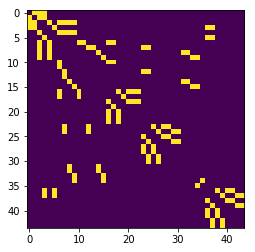

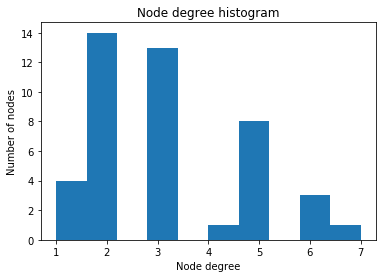

In [56]:
#2
#Transform graph to a matrix
A = nx.to_numpy_matrix(G)
#Undirected
A = A + A.transpose()
#Binarize
A = (A != 0) * 1
#Display adjancency matrix
plt.imshow(A)
plt.savefig('images/adj_matrix.png')
plt.show()

#Plot degree distribution
plt.hist(np.sum(A,axis=1))
plt.xlabel('Node degree')
plt.ylabel('Number of nodes')
plt.title('Node degree histogram')
plt.savefig('images/degree_histogram.png')
plt.show()

if 1 < 0:
    #We analize how network efficiency is affected by
    #Removing randomly 10 nodes.
    #We do it 10 times
    for t in range(0,10):
        G_c = G.copy()
        efficiency = []
        efficiency.append(nx.global_efficiency(G_c))

        for r in range(0,10):
            node_to_remove = random.randint(1,len(G_c.nodes()))
            G_c.remove_node(list(G_c.nodes())[node_to_remove - 1])
            efficiency.append(nx.global_efficiency(G_c))

        plt.plot(efficiency,'--')

    #We now analize how network efficiency is affected by
    #Removing nodes ordered from highest to lowest degree

    degree = []

    for node in G.nodes():
        degree.append(tuple((node,G.degree(node))))

    degree = sorted(degree,reverse=True, key=lambda tup: tup[1])

    G_c = G.copy()
    efficiency = []
    efficiency.append(nx.global_efficiency(G_c))
    for n in range(0,10):
        G_c.remove_node(degree[n][0])
        efficiency.append(nx.global_efficiency(G_c))
    plt.plot(efficiency,'r')

    plt.ylabel('Network Efficiency')
    plt.xlabel('Iteration')
    plt.savefig('images/exercice2.png')
    plt.show()


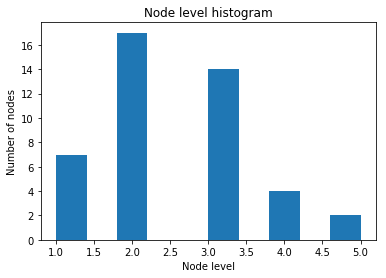

In [77]:
root = find_root_node(G)
level = np.zeros((len(G.nodes)),dtype=int)

def get_node_level(G,node,aux,l):
    if (aux == None): 
        return 0
    
    if node == aux:
        return l
    r = 0
    for edge in G.edges(aux):
            n1, n2 = edge
            color = G[n1][n2]['color']
            if aux == n1:
                dest = n2
            else:
                dest = n1
            if color == 'green':
                if node == dest:
                    return l
                continue
            r += get_node_level(G,node,dest,l + 1)
            
    return r

j = 0
for node in G.nodes():
    ret = get_node_level(G,node,root,1)
    level[j] = ret
    j += 1
    
for j in range (0,len(level)):
    level[j] = max(level) + 1 - level[j]
    
plt.hist(level)
plt.ylabel('Number of nodes')
plt.xlabel('Node level')
plt.title('Node level histogram')
plt.savefig('images/exercice3.png')
plt.show()
            